In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import tensorflow as tf
import keras
import math

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

UNKNOWN = 9

class MinesweeperEnv:

    def __init__(self, rows=9, columns=9, mines=10):

        self.rows = rows
        self.columns = columns
        self.mines = mines
        self.grid = None # мины
        self.state = np.full((rows, columns), UNKNOWN)  # открыта или нет
        self.state_one_hot = (np.arange(UNKNOWN+1) == self.state[...,None]).astype(int)
        self.reset_step = True
        self.unchosen_actions = np.ones((rows, columns)) # выбираемая

    def createGrid(self, start_row, start_column):
        grid = np.zeros((self.rows, self.columns), dtype=int)
        mines = self.mines

        while mines > 0:
            row = np.random.randint(0, self.rows)
            column = np.random.randint(0, self.columns)

            # если в клетке нет мины
            if (grid[row][column] == 0) and (row != start_row and column != start_column) :
                # place mine
                grid[row][column] = -1
                mines -= 1

        # отмечаем соседей
        for row in range(self.rows):
            for column in range(self.columns):
                if grid[row][column] != -1: # если не мина
                    grid[row][column] = self.surroundingMines(row, column, grid)

        self.grid = grid.copy()

    def surroundingMines(self, row, column, grid):
        mine_count = 0
        for r in [row-1, row, row+1]:
            for c in [column-1, column, column+1]:
                if (0 <= r < self.rows) and (0 <= c < self.columns):
                    if grid[r][c] == -1:
                        mine_count += 1
        return mine_count

    # для рекурсивного ...
    def anySurroundingRevealed(self, row, column):
        for r in [row-1, row, row+1]:
            for c in [column-1, column, column+1]:
                if (0 <= r < self.rows) and (0 <= c < self.columns) and not(r == row and c == column):
                    if self.state[r][c] != UNKNOWN:
                        return True
        return False

    def updateOneHot(self, row, column):
        one_hot_val = np.zeros(UNKNOWN + 1, dtype=int)
        one_hot_val[self.grid[row, column]] = 1
        self.state_one_hot[row, column] = one_hot_val

    def step(self, action):

        terminal = False

        if self.reset_step:
            self.createGrid(action[0], action[1])

        elif self.state[action[0], action[1]] != UNKNOWN:
            reward = -0.3
            return reward, terminal

        self.state[action[0], action[1]] = self.grid[action[0], action[1]]

        if self.reset_step:
            self.reset_step = False
            self.updateOneHot(action[0], action[1])
            reward = -0.3

        elif self.grid[action[0]][action[1]] == -1:
            self.reset()
            reward = -1
            terminal = True

        elif self.win():
            self.reset()
            reward = 1
            terminal = True

        elif self.anySurroundingRevealed(action[0], action[1]):
            self.updateOneHot(action[0], action[1])
            reward = 0.3

        else:
            self.updateOneHot(action[0], action[1])
            reward = -0.3

        self.unchosen_actions[action[0], action[1]] = 0

        return reward, terminal

    def win(self):
        covered = np.where(self.state == UNKNOWN)
        mines = np.where(self.grid == -1)
        if list(zip(covered[0], covered[1])) == list(zip(mines[0], mines[1])):
            return True
        return False

    def reset(self):
        self.reset_step = True
        self.grid = None
        self.state = np.full((self.rows, self.columns), UNKNOWN)
        self.state_one_hot = (np.arange(UNKNOWN+1) == self.state[...,None]).astype(int)
        self.unchosen_actions = np.ones((self.rows, self.columns))

    def drawEnv(self):
        moves = 0
        data = np.full((self.rows, self.columns),2)
        fig, ax = plt.subplots()
        for i in range(self.rows+1):
          ax.axhline(i, lw=2, color='k')
          ax.axvline(i, lw=2, color='k')
        ax.imshow(data, cmap="Greys", vmin=0, vmax=5, extent=[0, 9, 9, 0])
        ax.axis('off')
        display(fig)
        return fig, ax, data, moves

    def updateDrawing(self, fig, ax, data, moves, x, y):
        moves += 1
        if self.grid is None:
          if moves == (self.rows*self.columns)-self.mines:
            print("WON: all cells uncovered")
            ax.text(y+0.2,x+0.5,"WON",c="green")
          else:
            print("LOST: hit a mine at location", (x,y))
            ax.text(y+0.5,x+0.5,"M",c="red")
        else:
          ax.text(y+0.5,x+0.5,self.grid[x,y])
        data[x,y] = 1
        ax.imshow(data, cmap="Greys", vmin=0, vmax=5, extent=[0, 9, 9, 0])
        display(fig)
        return fig, ax, data, moves


'''
env = MinesweeperEnv()
fig, ax, data, moves = env.drawEnv()
x = int(input('Enter x value: '))
y = int(input('Enter y value: '))
while x != -1:
    print('Reward: ', env.step((x, y)))
    print('Grid:\n', env.grid)
    print('What agent sees:\n', env.state)
    fig, ax, data, moves = env.updateDrawing(fig, ax, data, moves, x, y)
    x = int(input('Enter x value: '))
    y = int(input('Enter y value: '))
'''


In [3]:
from collections import deque
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import optimizers
import random

GAMMA = 0.99
MINIBATCH_SIZE = 32
TARGET_MODEL_UPDATE_TIME = 10
MIN_REPLAY_MEMORY_SIZE = 1000

class DQAgent:

  def __init__(self, rows=9, columns=9):
    self.rows = rows
    self.columns = columns

    self.replayMem = deque(maxlen=10000)
    self.epsilon = 0.1
    self.learningRate = 0.001

    self.mainModel = self.createModel()
    self.targetModel = self.createModel()
    self.targetModel.set_weights(self.mainModel.get_weights())

    self.targetModelUpdateCounter = 0

  def createModel(self):
    model = Sequential([
                Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(9, 9, 10)),
                Conv2D(128, (3,3), activation='relu', padding='same'),
                Conv2D(128, (3,3), activation='relu', padding='same'),
                Conv2D(128, (3,3), activation='relu', padding='same'),
                Flatten(),
                Dense(512, activation='relu'),
                Dense(512, activation='relu'),
                Dense(81, activation='linear')])

    print(model.summary())

    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=self.learningRate), metrics=['accuracy'])
    return model

  def updateReplayMemory(self, currentState, action, reward, nextState, terminalState):
    self.replayMem.append((currentState, action, reward, nextState, terminalState))

  def train(self, terminal):

    if len(self.replayMem) < MIN_REPLAY_MEMORY_SIZE:
      return

    minibatch = random.sample(self.replayMem, MINIBATCH_SIZE)
    currentStates = []
    nextStates = []
    for sample in minibatch:
      currentStates.append(sample[0])
      nextStates.append(sample[3])

    currentQVals = self.mainModel.predict(np.array(currentStates))
    nextQVals = self.targetModel.predict(np.array(nextStates))

    states = []
    updatedQVals = []

    for index, (currentState, action, reward, nextState, terminalState) in enumerate(minibatch):
      if terminalState:
        updatedQVal = reward
      else:
        updatedQVal = reward + (GAMMA * np.max(nextQVals[index]))

      currentQsForState = currentQVals[index]
      currentQsForState[(action[0] * self.columns) + action[1]] = updatedQVal

      states.append(currentState)
      updatedQVals.append(currentQsForState)

    self.mainModel.fit(np.array(states), np.array(updatedQVals), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

    if terminal:
      self.targetModelUpdateCounter += 1

    if self.targetModelUpdateCounter > TARGET_MODEL_UPDATE_TIME:
      self.targetModel.set_weights(self.mainModel.get_weights())
      self.targetModelUpdateCounter = 0



In [13]:
def chooseAction(agent, state, unchosen):
  if np.random.random() < agent.epsilon:
    actions = np.argwhere(unchosen)
    index = np.random.randint(0,len(actions))
    action = actions[index]

  else:
    pred = agent.mainModel.predict(np.array(state).reshape(-1, *state.shape))
    unchosen = unchosen.reshape(1, 81)
    pred[unchosen == 0] = np.min(pred)
    index = np.argmax(pred)
    action = convertIndexToAction(index, agent)
  return action


def convertIndexToAction(index, agent):
  row = math.floor(index / agent.columns)
  column = index - (row * agent.columns)
  return (row, column)


def train(agent, env, num_episodes=10000):
  rewards = []
  episodes = []
  steps = []

  for episode in range(num_episodes):
    step = 0

    current_state = env.state_one_hot

    terminal = False
    sumRewards = 0

    while not terminal:
      step += 1

      action = chooseAction(agent, current_state, env.unchosen_actions)

      reward, terminal = env.step(action)
      sumRewards += reward
      next_state = env.state_one_hot

      agent.updateReplayMemory(current_state, action, reward, next_state, terminal)

      agent.train(terminal)

      current_state = next_state

    print(episode)

    rewards.append(sumRewards)
    episodes.append(episode)
    steps.append(step)

  plt.clf()
  plt.plot(episodes,rewards)
  plt.show()
  plt.plot(episodes, steps)
  plt.show()


def evaluate(agent, env, num_episodes=1):
  agent.epsilon = 0

  for episode in range(num_episodes):
    current_state = env.state_one_hot
    fig, ax, data, moves = env.drawEnv()
    terminal = False
    while not terminal:
      action = chooseAction(agent, current_state, env.unchosen_actions)
      print(action)
      reward, terminal = env.step(action)
      fig, ax, data, moves = env.updateDrawing(fig, ax, data, moves, action[0], action[1])
      next_state = env.state_one_hot

      current_state = next_state


Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 71ms/step
326
1/1 [==============================] - 0s 130ms/step
327
1/1 [==============================] - 0s 70ms/step
328
1/1 [==============================] - 0s 76ms/step
329
1/1 [==============================] - 0s 73ms/step
330
1/1 [==============================] - 0s 72ms/step
331
1/1 [==============================] - 0s 68ms/step
332
1/1 [==============================] - 0s 65ms/step
333
1/1 [==============================] - 0s 134ms/step
334
1/1 [==============================] - 0s 84ms/step
335
1/1 [==============================] - 0s 74ms/step
336
1/1 [==============================] - 0s 70ms/step
337
1/1 [==============================] - 0s 108ms/step
338
1/1 [==============================] - 0s 108ms/step
339
1/1 [==============================] - 0s 65ms/step
340
1/1 [==============================] - 0s 75ms/step
341
1/1 [===========================

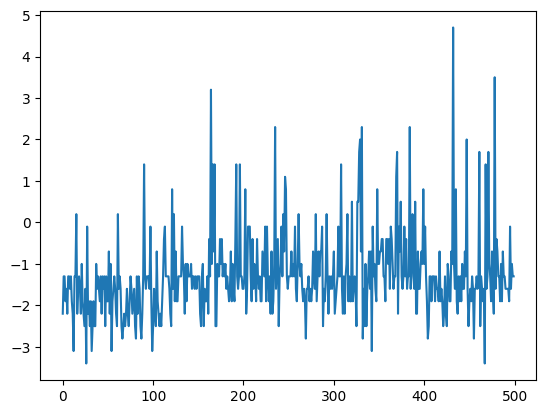

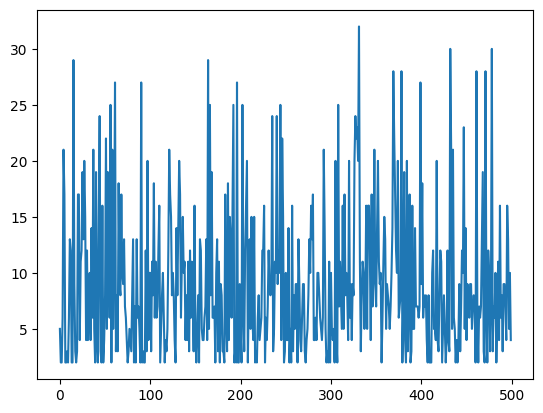

In [45]:
dq_agent = DQAgent()
environment = MinesweeperEnv()

train(dq_agent, environment, 500)

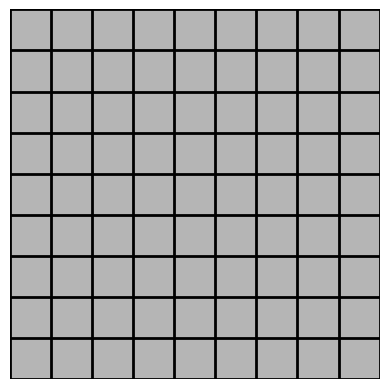

1/1 [==============================] - 0s 31ms/step
(3, 5)


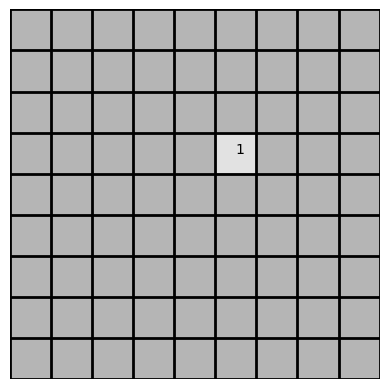

1/1 [==============================] - 0s 31ms/step
(3, 1)


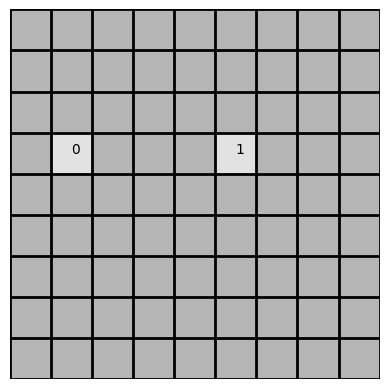

1/1 [==============================] - 0s 30ms/step
(3, 4)


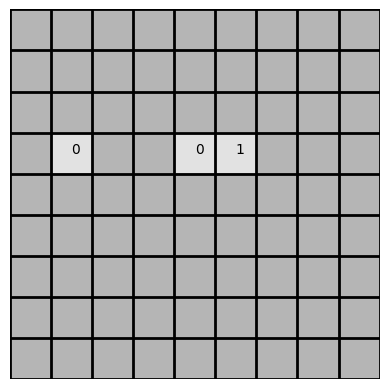

1/1 [==============================] - 0s 29ms/step
(3, 2)


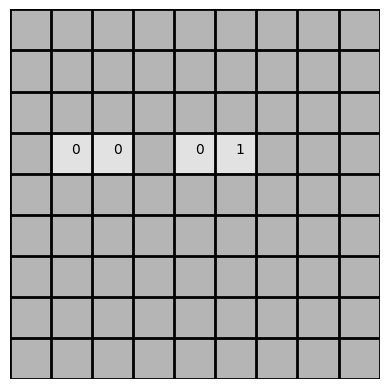

1/1 [==============================] - 0s 29ms/step
(3, 0)


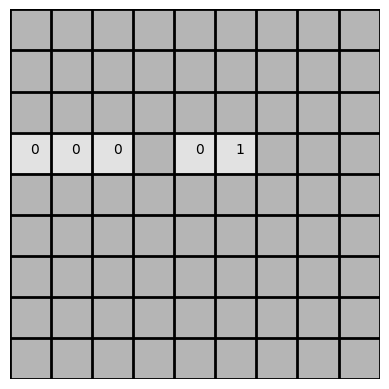

1/1 [==============================] - 0s 28ms/step
(0, 0)


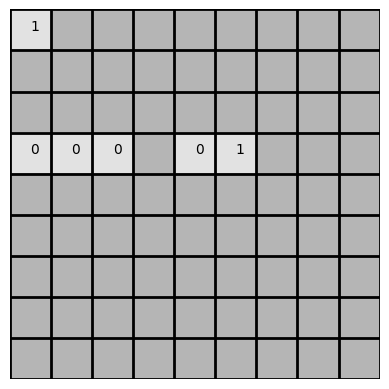

1/1 [==============================] - 0s 29ms/step
(3, 3)


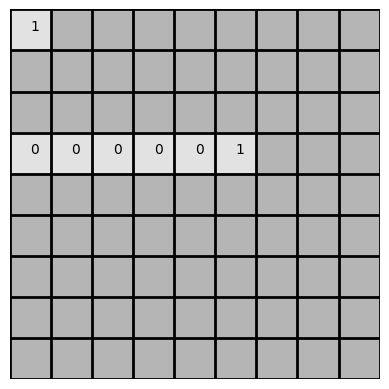

1/1 [==============================] - 0s 29ms/step
(6, 0)


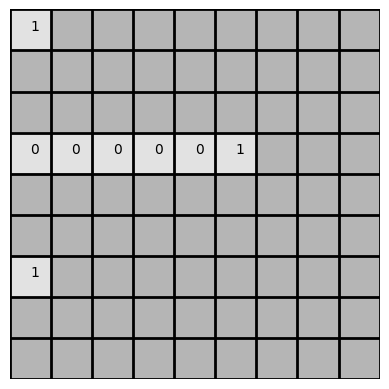

1/1 [==============================] - 0s 31ms/step
(0, 5)


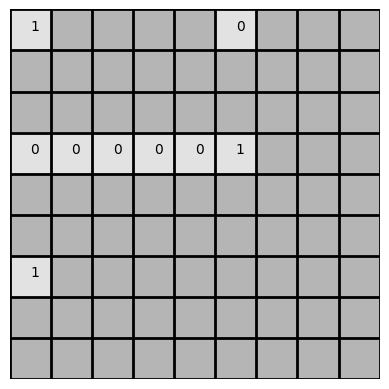

1/1 [==============================] - 0s 28ms/step
(6, 2)


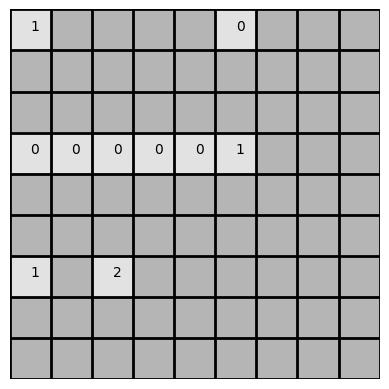

1/1 [==============================] - 0s 27ms/step
(4, 1)


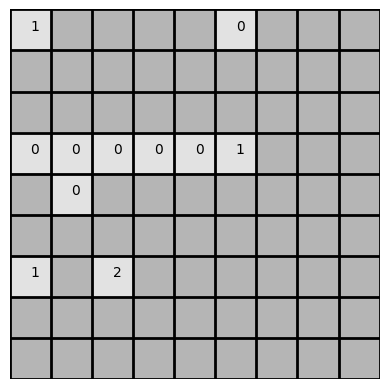

1/1 [==============================] - 0s 31ms/step
(8, 2)


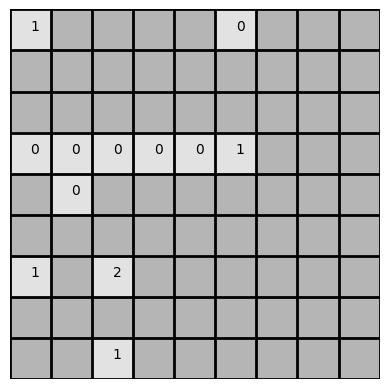

1/1 [==============================] - 0s 34ms/step
(8, 1)


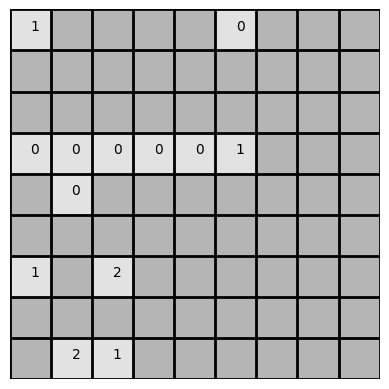

1/1 [==============================] - 0s 29ms/step
(2, 2)


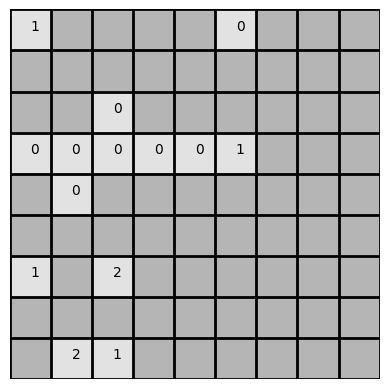

1/1 [==============================] - 0s 29ms/step
(1, 4)


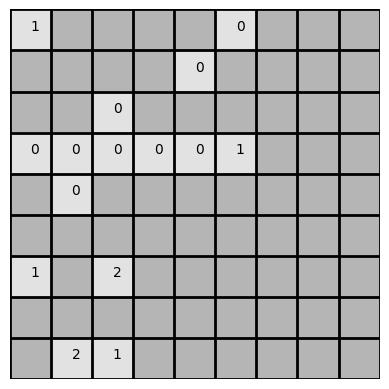

1/1 [==============================] - 0s 30ms/step
(0, 8)


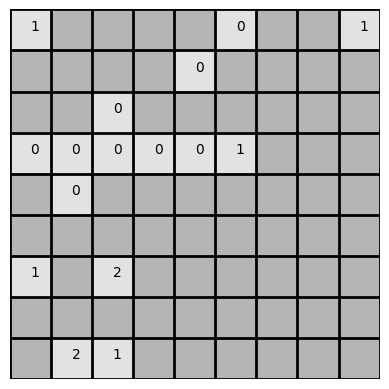

1/1 [==============================] - 0s 32ms/step
(4, 3)


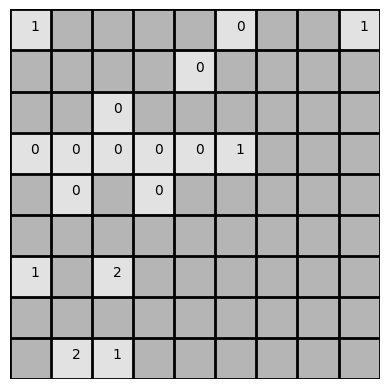

1/1 [==============================] - 0s 44ms/step
(8, 3)


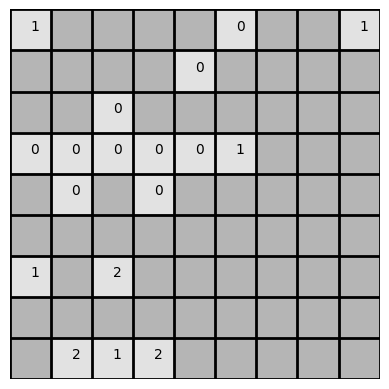

1/1 [==============================] - 0s 56ms/step
(1, 5)


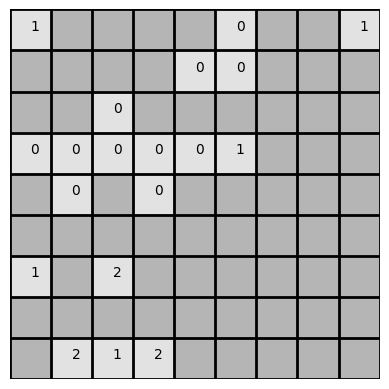

1/1 [==============================] - 0s 43ms/step
(2, 3)


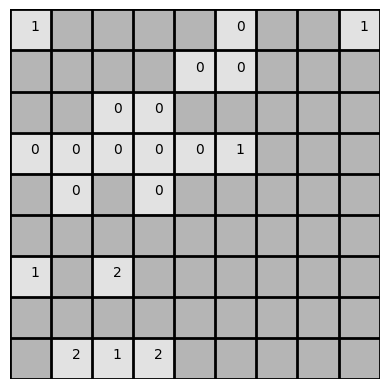

1/1 [==============================] - 0s 48ms/step
(7, 3)


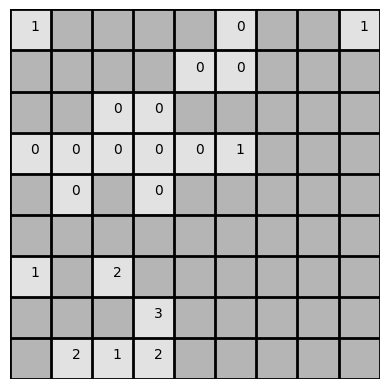

1/1 [==============================] - 0s 28ms/step
(5, 2)


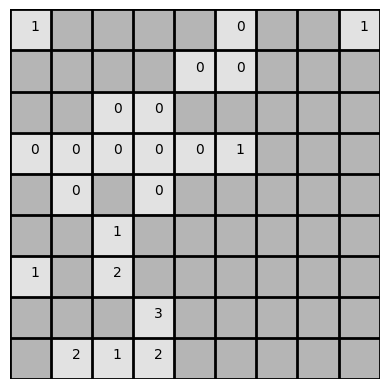

1/1 [==============================] - 0s 27ms/step
(0, 4)


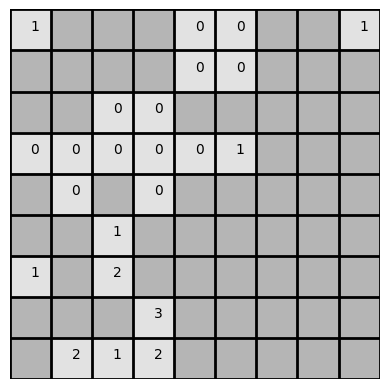

1/1 [==============================] - 0s 29ms/step
(6, 5)


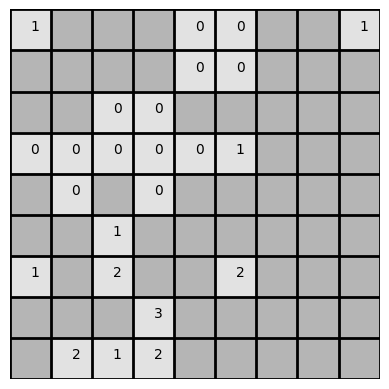

1/1 [==============================] - 0s 27ms/step
(7, 2)
LOST: hit a mine at location (7, 2)


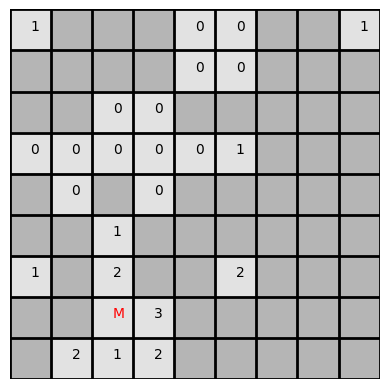

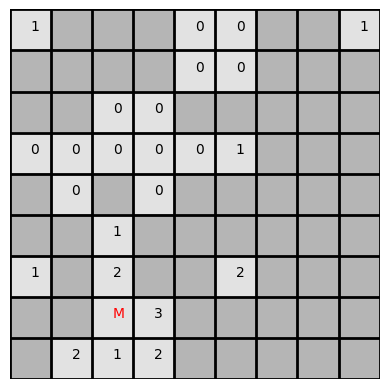

In [63]:
evaluate(dq_agent, environment)